(sec:structopt-methods)=
# Optimization methods

The first class of special points on the PES that we will discuss are local energy minima. These correspond to equilibrium molecular structures and are characterized by a vanishing first order energy derivative combined with a Hessian matrix which has only positive eigenvalues. The procedure to determine a local minimum (i.e. finding the coordinates that minimize the energy) is called a structure optimization.  

```{figure} ../../img/pes/PES.png
```
In practical terms, the ingredients to perform a geometry optimization include: (1) the initial molecular coordinates, (2) a choice of coordinate system, (3) the energy at a specific geometry $E(\mathbf{x})$, (4) the gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$, (5) the Hessian, and (6) a procedure to update the coordinates and Hessian and move on the potential energy surface towards lower energy. 

Having addressed [the issue of coordinate system](sec:coord), the remaining question is what procedure to use to move along the potential energy surface and arrive at a local energy minimum. There are several iterative methods to do this, some of which need only information on the energy gradient (e.g. gradient-descent, conjugate gradient), while others take into account also the Hessian (Newton--Raphson, quasi-Newton). For a detailed review of minimization techniques, see {cite}`Snyman2005`.

In the following, we will illustrate the performance of different optimization methods using a mathematical 2D function for which we can visualize the surface and calculate the gradient and Hessian analytically.

In [1]:
# Import section
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from veloxchem.veloxchemlib import bohr_in_angstroms

[emi-IdeaPad-Slim-5-16ABR8:195312] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 16.


Let us define a function and represent it graphically.

In [2]:
def f(x, y):
    return -x**4 / 40.0 + x**2 - y**2 - 50.0 * np.exp(-(x**2 + y**2)/10.0)

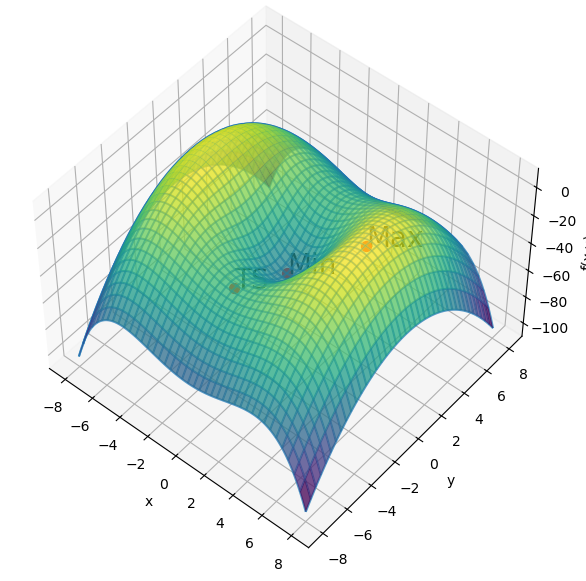

In [16]:
# Let's represent the function graphically
# First, we need to create the X,Y grid
x = np.arange(-8, 8.01, 0.1)
y = np.arange(-8, 8.01, 0.1)
X, Y = np.meshgrid(x, y)

# Next, we have to calculate the value of f at each point on the grid
Z = f(X, Y)

# Add a wireframe and a 
# partly translucent surface plot on top of each other
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, alpha=0.75)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.75)

# Side view
ax.view_init(50, -50)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')

# Label the special points on the surface
# Minimum
x1 = 0
y1 = 0
st = 'Min'

ax.scatter(x1, y1, f(x1, y1), s=50, color='red')
ax.text(x1, y1, f(x1, y1), st, size=20, color='black')

# Saddle point
x2 = 0
y2 = -4.2
st = 'TS'

ax.scatter(x2, y2, f(x2, y2), s=50, color='red')
ax.text(x2, y2, f(x2, y2), st, size=20, color='black')

# Maximum
x3 = 5.25
y3 = 0
st = 'Max'

ax.scatter(x3, y3, f(x3, y3), s=50, color='red')
ax.text(x3, y3, f(x3, y3), st, size=20, color='black')

plt.show()

## Gradient descent

The simplest optimization procedure is to repeatedly take a step in the direction opposite to the local gradient
%
\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i - k_i\mathbf{g}(\mathbf{x}_i) \nonumber 
\end{equation}
where by $\mathbf{x}_{i+1}$ we denote the new coordinates (in a generic coordinate system -- either Cartesian or internal coordinates), $\mathbf{x}_i$ are the coordinates at the previous step $i$, $\nabla E$ is the energy gradient and $k_i$ is the step size. The step size can either be kept constant, or adjusted at each iteration, e.g. by the line search procedure.

The gradient-descent method is simple to implement and is guaranteed to converge, but has the disadvantage that it requires many steps and becomes slow when close to the minimum where the gradient is small. It always converges to a local minimum, given enough steps.


### Implementation
Let's implement the gradient descent method. We will need to set prepare a routine which determines the gradient of our function $f(x, y)$.

In [17]:
# Now we need to calculate the gradient
def grad_f(x, y):

    partial_x = -(x**3) / 10.0 + 2 * x + 10.0 * x * np.exp(-(x**2 + y**2)/10.0)
    partial_y = -2 * y + 10.0 * y * np.exp(-(x**2 + y**2)/10.0)
    
    return np.array([partial_x, partial_y])

Now, we can write the routine to run the gradient descent algorithm:

In [35]:
def gradient_descent(x0, y0, function, gradient, k = 0.025,
                     conv_thresh=1e-5, max_iter=100):
    """ Performs an optimization using the gradient descent algorithm
        for a two-variable function.

        :param x0         : the starting x-coordinate.
        :param y0         : the starting y-coordinate.
        :param function   : the function.
        :param gradient   : the gradient.
        :param k          : gradient descent step size.
        :param conv_thresh: the convergence threshold.
        :param max_iter   : the maximum number of iterations.
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)

    i = 0 # current iteration
    
    grad_norm = np.linalg.norm(g0)
    opt_data = {'points': [(x0, y0)], 'function_values':[f0], 'gradient_norms': [grad_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (grad_norm >= conv_thresh)):
        # Update x and y to take a step in the opposite direction of the gradient
        x = x0 - k * g0[0]
        y = y0 - k * g0[1]

        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)

        grad_norm = np.linalg.norm(g)

        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(grad_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        g0 = g

        if grad_norm < conv_thresh:
            print("Converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [36]:
gradient_descent_opt_data = gradient_descent(x0=-3.0, y0=1.9, function=f,
                                             gradient=grad_f,
                                             k=0.025, conv_thresh=1e-5,
                                             max_iter=100)

Converged in 69 iterations!


Let us represent the trajectory graphically.

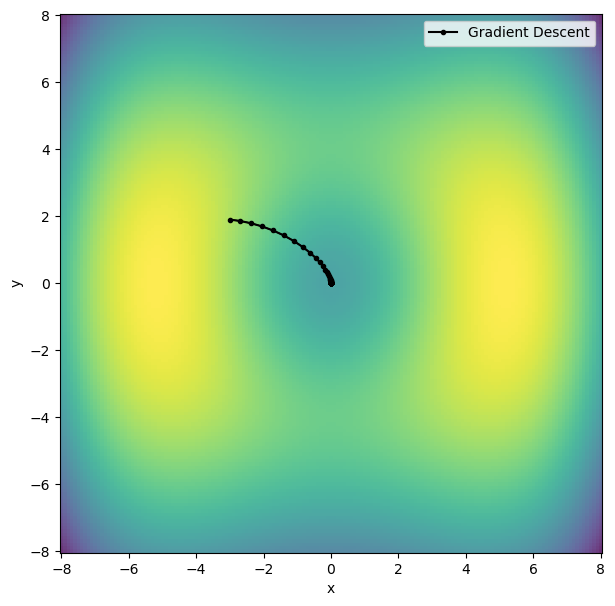

In [26]:
traj_gradient_descent = gradient_descent_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line, = ax.plot(xpath, ypath, '.-', color="black", label="Gradient Descent")
ax.add_patch(patch)

plt.legend()
plt.show()

## Conjugate gradient
An improved method over the gradient-descent approach is to use the "gradient history" (steps $i$ and $i-1$) to determine the coordinates at step $i+1$

\begin{equation}
    \mathbf{x}_{i+1} = \mathbf{x}_i - k_i \mathbf{h}_i \nonumber
\end{equation}
with $\mathbf{h}_i = \mathbf{g}(\mathbf{x}_i)+\gamma_i\mathbf{h}_{i-1}$. The function $\gamma_i$ contains gradient information from steps $i$ and $i-1$ and can be defined in different ways. For example, in the Fletcher-Reeves conjugate gradient method

\begin{equation}
    \gamma_i = \frac{|\mathbf{g}(\mathbf{x}_i)|^2}{|\mathbf{g}(\mathbf{x}_{i-1})|^2} \nonumber
\end{equation}

Another option, is the Polak-Ribiere method,
\begin{equation}
    \gamma_i = \frac{\left[\mathbf{g}(\mathbf{x}_i)-\mathbf{g}(\mathbf{x}_{i-1})\right]^\mathrm{T}\mathbf{g}(\mathbf{x}_i)}{|\mathbf{g}(\mathbf{x}_{i-1})|^2} \nonumber
\end{equation}

### Implementation
Let us now implement the conjugate gradient optimization algorithm and compare its performance to the gradient descent method.

In [37]:
def conjugate_gradient(x0, y0, function, gradient, k = 0.025,
                       conv_thresh=1e-5, max_iter=100,
                       method="Fletcher-Reeves"):
    """ Performs an optimization using the conjugate gradient algorithm
        for a two-variable function.

        :param x0         : the starting x-coordinate.
        :param y0         : the starting y-coordinate.
        :param function   : the function.
        :param gradient   : the gradient.
        :param k          : conjugate gradient step size.
        :param conv_thresh: the convergence threshold.
        :param max_iter   : the maximum number of iterations.
        :param method     : the conjugate gradient method
                            (Fletcher-Reeves, or Polak-Ribiere).
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)

    i = 0 # current iteration
    # the first step in conjugate gradient is the same as for gradient descent.
    h0 = g0 
    
    g0_norm = np.linalg.norm(g0)
    opt_data = {'points': [(x0, y0)], 'function_values':[f0],
                'gradient_norms': [g0_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (g0_norm >= conv_thresh)):
        # Update x and y to take a step in the opposite direction
        # of the gradient
        x = x0 - k * h0[0]
        y = y0 - k * h0[1]
        
        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)

        g_norm = np.linalg.norm(g)

        if method == "Fletcher-Reeves":
            gamma = g_norm**2 / g0_norm**2
        elif method == "Polak-Ribiere":
            gamma = np.dot((g - g0).T, g) / g0_norm**2
        else:
            error_txt = "Unknown conjugate gradient method."
            error_txt += " Please use Fletcher-Reeves or Polak-Ribiere."
            raise ValueError(error_txt)
        h = g + gamma * h0
        
        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(g_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        h0 = h
        g0 = g
        g0_norm = g_norm

        if g_norm < conv_thresh:
            print(method + " converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [29]:
cg_fletcher_reeves_opt_data = conjugate_gradient(x0=-3.0, y0=1.9, function=f, gradient=grad_f,
                                                 k=0.025, conv_thresh=1e-5, max_iter=120,
                                                 method="Fletcher-Reeves")

cg_polak_ribiere_opt_data = conjugate_gradient(x0=-3.0, y0=1.9, function=f, gradient=grad_f,
                                               k=0.025, conv_thresh=1e-5, max_iter=120,
                                               method="Polak-Ribiere")

Fletcher-Reeves converged in 118 iterations!
Polak-Ribiere converged in 81 iterations!


Let's plot the conjugate gradient results in comparison to gradient descent.

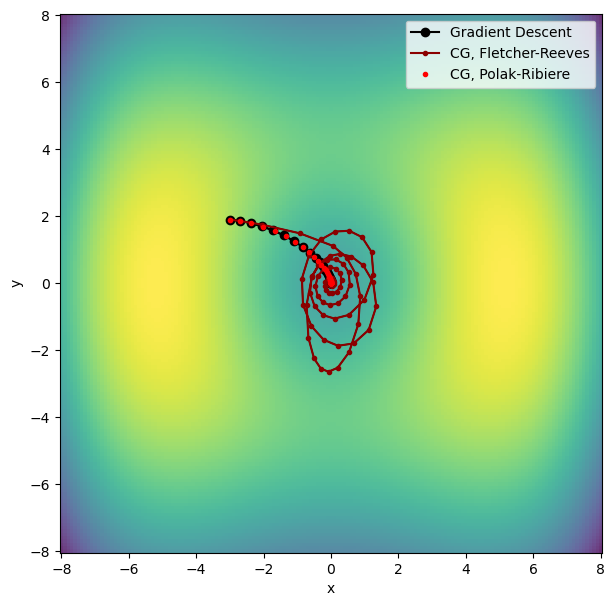

In [30]:
traj_cg_fr = cg_fletcher_reeves_opt_data['points']
traj_cg_pr = cg_polak_ribiere_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line = ax.plot(xpath, ypath, 'o-', color="black", label="Gradient Descent")
ax.add_patch(patch)

# Plot the conjugate gradient trajectory
Traj_fr = Path(traj_cg_fr)
patch_fr = PathPatch(Traj_fr, facecolor='none')
xpath_fr, ypath_fr = zip(*Traj_fr.vertices)
line_fr = ax.plot(xpath_fr, ypath_fr, '.-', color="darkred", label="CG, Fletcher-Reeves")
ax.add_patch(patch_fr)

Traj_pr = Path(traj_cg_pr)
patch_pr = PathPatch(Traj_pr, facecolor='none')
xpath_pr, ypath_pr = zip(*Traj_pr.vertices)
line_pr = ax.plot(xpath_pr, ypath_pr, '.', color="red", label="CG, Polak-Ribiere")
ax.add_patch(patch_pr)

plt.legend()
plt.show()

## Newton--Raphson
The next step in the hierarchy of minimization methods is to use both the first and second order energy derivatives (i.e. gradient $\mathbf{g}$ and Hessian $\mathbf{H}$) in determining the next step in conformation space. This is based on a quadratic approximation for the local shape of the PES
$$
    E(\mathbf{x}+\Delta\mathbf{x}) \approx E(\mathbf{x}) + \mathbf{g}(\mathbf{x})\Delta\mathbf{x} + \frac{1}{2}\Delta\mathbf{x}^\mathrm{T}\mathbf{H}\Delta\mathbf{x}
$$

Here, $\Delta \mathbf{x}$ is the Newton step used to update the coordinates

 \begin{align}
    \Delta \mathbf{x} &= -\mathbf{H}^{-1}\mathbf{g}(\mathbf{x})\\
    \mathbf{x}_\mathrm{i+1} &= \mathbf{x}_\mathrm{i}+\Delta \mathbf{x}
 \end{align}

### Implementation
In the following, we will implement the Newton-Raphson optimization algorithm. For this, we need to write a routine which computes the Hessian of our mathematical function.

In [38]:
def hessian_f(x, y):

    partial_xx = ( -3 * x**2 / 10.0 + 2 + 10.0 * np.exp(-(x**2 + y**2)/10.0)
                  - 2 * x**2 * np.exp(-(x**2 + y**2)/10.0)
                 )
    partial_xy =  - 2 * x * y * np.exp(-(x**2 + y**2)/10.0)
    partial_yx = partial_xy
    partial_yy = -2 + 10.0 * np.exp(-(x**2 + y**2)/10.0) - 2 * y**2 * np.exp(-(x**2 + y**2)/10.0)
    
    return np.array([[partial_xx, partial_xy],[partial_yx, partial_yy]])

Using the Hessian, we can now implement the Newton-Raphson algorithm:

In [32]:
def newton_raphson(x0, y0, function, gradient, hessian, conv_thresh=1e-5,
                   max_iter=100, trust_radius=None):
    """ Performs an optimization using the Newton-Raphson algorithm
        for a two-variable function.

        :param x0          : the starting x-coordinate.
        :param y0          : the starting y-coordinate.
        :param function    : the function.
        :param gradient    : the gradient.
        :param hessian     : the Hessian.
        :param conv_thresh : the convergence threshold.
        :param max_iter    : the maximum number of iterations.
        :param trust_radius: the trust radius.
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)
    h0 = hessian(x0, y0)

    # the inverse of the Hessian matrix
    inv_h0 = np.linalg.inv(h0)

    i = 0 # current iteration
    
    g_norm = np.linalg.norm(g0)
    delta_r = -np.dot(inv_h0, g0)
    
    opt_data = {'points': [(x0, y0)], 'function_values':[f0],
                'gradient_norms': [g_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (g_norm >= conv_thresh)):
        if trust_radius is not None:
            steplen = np.linalg.norm(delta_r)
            if steplen > trust_radius:
                # If proposed step exceeds trust radius,
                # then decrease step length to trust radius
                delta_r /= (steplen / trust_radius)
            
        # Update x and y
        x = x0 + delta_r[0]
        y = y0 + delta_r[1]

        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)
        h = hessian(x, y)
        
        inv_h = np.linalg.inv(h)
        delta_r = -np.dot(inv_h, g)
        g_norm = np.linalg.norm(g)
      
        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(g_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        
        if g_norm < conv_thresh:
            print("Converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [33]:
newton_raphson_opt_data = newton_raphson(x0=-3.0, y0=1.9, function=f,
                                         gradient=grad_f,
                                         hessian=hessian_f,
                                         conv_thresh=1e-5,
                                         max_iter=120,
                                         trust_radius=1.0)

Converged in 7 iterations!


Let's plot the trajectory followed by the Newton-Raphson optimization and compare it with gradient descent and conjugate gradient.

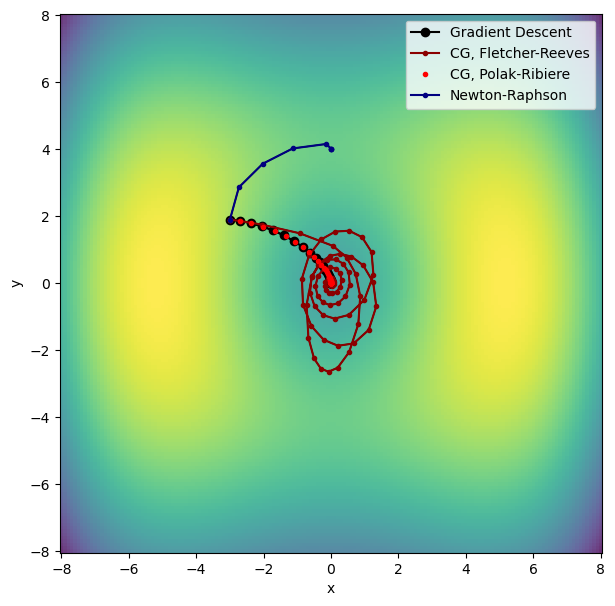

In [34]:
traj_newton_raphson = newton_raphson_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line = ax.plot(xpath, ypath, 'o-', color="black", label="Gradient Descent")
ax.add_patch(patch)

# Plot the conjugate gradient trajectory
Traj_fr = Path(traj_cg_fr)
patch_fr = PathPatch(Traj_fr, facecolor='none')
xpath_fr, ypath_fr = zip(*Traj_fr.vertices)
line_fr = ax.plot(xpath_fr, ypath_fr, '.-', color="darkred", label="CG, Fletcher-Reeves")
ax.add_patch(patch_fr)

Traj_pr = Path(traj_cg_pr)
patch_pr = PathPatch(Traj_pr, facecolor='none')
xpath_pr, ypath_pr = zip(*Traj_pr.vertices)
line_pr = ax.plot(xpath_pr, ypath_pr, '.', color="red", label="CG, Polak-Ribiere")
ax.add_patch(patch_pr)

# Plot the Newton-Raphson trajectory
Traj_nr = Path(traj_newton_raphson)
patch_nr = PathPatch(Traj_nr, facecolor='none')
xpath_nr, ypath_nr = zip(*Traj_nr.vertices)
line_nr = ax.plot(xpath_nr, ypath_nr, '.-', color="navy", label="Newton-Raphson")
ax.add_patch(patch_nr)

plt.legend()
plt.show()

The Newton-Raphson algorithm converges very fast, but it converges to the nearest stationary point. This can be a transition state, rather than a local minimum, as shown by the graph above. For this reason, one must always make sure that the coordinates found by Newton-Raphson correspond to a minimum, e.g. by checking that the Hessian has no imaginary eigenvalues.

## Quasi-Newton

The methods illustrated here can easily be adapted to use the molecular energy gradient and molecular coordinates and obtain optimized molecular structures. However, in the case of the Newton-Raphson method, the second order derivatives of the energy with respect to nuclear displacements are required to generate the Newton step. The direct computation of these derivatives (which compose the Hessian matrix) is quite expensive, but good _approximations_ for the Hessian can be constructed using the gradient history. For example, the Broyden-Fletcher-Goldfarb-Shanno (BFGS, used by [geomeTRIC](https://github.com/leeping/geomeTRIC)) approach uses the relation:
%
\begin{align}
\mathbf{H}_{i+1} &= \mathbf{H}_i + \frac{\mathbf{h}^{}_i\mathbf{h}_i^\mathrm{T}}{\mathbf{h}_i^\mathrm{T}\mathbf{s}^{}_i} - \frac{\mathbf{H}_i\mathbf{s}_i\left(\mathbf{H}_i\mathbf{s}_i\right)_{}^\mathrm{T}}{\mathbf{s}_i^\mathrm{T}\mathbf{H}_i^{}\mathbf{s}_i^{}} \, ,\nonumber
\end{align}
with,
\begin{align}
\mathbf{h}_i &= \mathbf{g}(\mathbf{x}_{i+1}) - \mathbf{g}(\mathbf{x}_i) \, \nonumber \\
\mathbf{s}_i &= \mathbf{x}_{i+1} - \mathbf{x}_{i} \nonumber \,,
\end{align}

to update the Hessian at step $i+1$ using the Hessian at step $i$ and information about the gradient at the current and previous step.

This method is the typical one used in molecular geometry optimization because it achieves a very quick convergence at the same computational cost as gradient-descent. The steps of a molecular geometry optimization are illustrated in the figure below.

```{figure} ../../img/pes/geom_opt_flowchart.svg
:scale: 100%
```

````{admonition} Note
:class: note
Geometry optimizations can be run using differet coordinate systems. For example, [geomeTRIC](https://github.com/leeping/geomeTRIC) offers: Cartesian coordinates, delocalized internal coordinates (DLC), hybrid delocalized internal coordinates (HDLC), as well as translation-rotation internal coordinates (TRIC). The choice of coordinates can, to some extent, influence the optimization process. In particular, some care must be taken when redundant internal coordinates are used. In this case, it is important to ensure that the displacements are only performed in the non-redundant region of the internal coordinate space. This can be achieved by applying a projector $\mathbf{P}=\mathbf{G}^{-}\mathbf{G}$ to the gradient and Hessian before constructing the Newton step {cite}`orcamanual`:
 
 \begin{align}
 \tilde{\mathbf{g}}_q &= \mathbf{P}\mathbf{g}(\mathbf{q}) \, , \nonumber \\
 \tilde{\mathbf{H}}_q &= \mathbf{P}\mathbf{H}_q\mathbf{P}+\alpha(1-\mathbf{P}) \nonumber \,,
 \end{align}

where $\alpha$ is an arbitrary large value (e.g. 1000).
%\textcolor{red}{I haven't perfectly understood what $\alpha$ does yet. The exact quote from the ORCA manual is "The second term for H sets the matrix elements of the redundant part of the internal coordinate space to very large values ($\alpha$ = 1000)"}
````